In [1]:
# 📦 导入依赖
import ROOT
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import gamma as gamma_dist
from scipy.stats import lognorm as log_normal_dist
from scipy.stats import norm as gaussian_dist
from scipy.optimize import curve_fit
import pandas as pd
import os
plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
fig_size = (8, 6)
# 🔧 解码函数：根据 bitfield <id>calolayer:7,abslayer:1,cellid:13</id>
def decode_volid(volid):
    volid = int(volid)
    calolayer = volid & 0x7F                 # bits 0–6
    abslayer  = (volid >> 7) & 0x1           # bit 7
    cellid    = (volid >> 8) & 0x1FFF        # bits 8–20
    return calolayer, abslayer, cellid

# 🧮 从 cellid 解出 index_x/y/z（若 cellid = z*1600 + y*40 + x）
def decode_indices(cellid):
    index_z = cellid // 1600
    index_y = (cellid % 1600) // 40
    index_x = cellid % 40
    return index_x, index_y, index_z


/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/grid_mnt/data__DATA/data.polcalice/data/flc/shi/miniconda3/envs/my_notebook_env/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               

Welcome to JupyROOT 6.28/04


In [2]:
# 打开 ROOT 文件，载入 events tree
DataPath_Validate="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Train="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"
DataPath_Uniform="/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/Uniform"
Energy_Train=(0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,15.0,25.0,35.0,45.0,55.0,65.0)
#Energy_Train=(0.5,)
Energy_Val=(0.5,1.0,2.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0)
Threshold=0.5*0.1328
#MIP=(0.0410,0.0861,0.1328,0.1803,0.2282)# for Si 0.15mm,0.3mm,0.45mm,0.6mm,0.75mm. Unit is MeV
ECAL_layers=30
def ReadData_Energy(DataPath,ParticleEnergy):
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for i_E in range(len(ParticleEnergy)):
    #for i_E in range(0,1):
        input_file_name = f"{DataPath}/{ParticleEnergy[i_E]}GeV.root"
        E_layers,N_layers,E_truth = ReadRoot(input_file_name)
        E_layers_all = np.vstack((E_layers_all, np.vstack(E_layers)))
        N_layers_all = np.vstack((N_layers_all, np.vstack(N_layers)))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadData_Uniform(DataPath):
    root_files = [os.path.join(DataPath, f) for f in os.listdir(DataPath) if f.endswith(".root")]
    if len(root_files) == 0:
        raise FileNotFoundError(f"No .root files found in {DataPath}")
    E_layers_all = np.empty((0, ECAL_layers))
    N_layers_all = np.empty((0, ECAL_layers))
    E_truth_all  = np.empty((0,))
    for input_file in root_files:
        E_layers, N_layers, E_truth = ReadRoot(input_file)
        E_layers_all = np.vstack((E_layers_all, E_layers))
        N_layers_all = np.vstack((N_layers_all, N_layers))
        E_truth_all  = np.concatenate((E_truth_all, E_truth))
    return E_layers_all, N_layers_all, E_truth_all
def ReadRoot(input_file_name):
    print(f"Processing file: {input_file_name}")
    input_file = uproot.open(input_file_name)
    tree = input_file["events"]
    cellID = tree["simplecaloRO.cellID"].array(library="ak")
    energy = tree["simplecaloRO.energy"].array(library="ak")
    pos_x  = tree["simplecaloRO.position.x"].array(library="ak")
    pos_y  = tree["simplecaloRO.position.y"].array(library="ak")
    pos_z  = tree["simplecaloRO.position.z"].array(library="ak")
    #MCP_px = tree["MCParticles.momentum.x"].array(library="np")
    #MCP_py = tree["MCParticles.momentum.y"].array(library="np")
    #MCP_pz = tree["MCParticles.momentum.z"].array(library="np")
    E_truth = tree["MCParticles.p0"].array(library="ak")
    threshold_mask = energy * 1000 > Threshold
    cellID = cellID[threshold_mask]
    energy = energy[threshold_mask]
    pos_x = pos_x[threshold_mask]
    pos_y = pos_y[threshold_mask]
    pos_z = pos_z[threshold_mask]
    calo_layer = cellID & 0x7F
    #print to check
    # sorted_indices = np.argsort(calo_layer[0])
    # energy_sorted = energy[0][sorted_indices].to_numpy()
    # layer_sorted = calo_layer[0][sorted_indices].to_numpy()
    # posz_sorted = pos_z[0][sorted_indices].to_numpy()
    # print("Event 0 (sorted by layer):")
    # for l, e, z in zip(layer_sorted, energy_sorted, posz_sorted):
    #     print(f"  Layer {l:2d} | Energy = {e:.5f} | PosZ = {z:.5f }")

    num_events = len(energy)
    E_layers = []
    N_layers = []
    for i_event in range(num_events):
        # convert to numpy arrays
        layers = calo_layer[i_event].to_numpy()
        energies = energy[i_event].to_numpy()
        E_layers_event = np.bincount(layers, weights=energies, minlength=ECAL_layers)
        N_layers_event = np.bincount(layers, minlength=ECAL_layers)
        E_layers.append(E_layers_event)
        N_layers.append(N_layers_event)

    #print("Event 0:")
    #for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
    #    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
    E_truth_flat = ak.to_numpy(ak.flatten(E_truth, axis=None))
    return E_layers,N_layers,E_truth_flat
#Read Data
E_layers_train, N_layers_train, E_truth_train = ReadData_Energy(DataPath_Train,Energy_Train)
E_layers_validate, N_layers_validate, E_truth_validate = ReadData_Energy(DataPath_Validate,Energy_Val)
E_layers_uniform, N_layers_uniform, E_truth_uniform = ReadData_Uniform(DataPath_Uniform)

Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/0.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/1.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/2.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/3.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/4.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/5.5GeV.root
Processing file: /home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Train/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60/6.5GeV.root

In [ ]:
#Read Data
plt.figure(figsize=fig_size)
plt.hist(E_truth_train, bins=1000, range=(0, 100), edgecolor="black")
plt.xlabel("E_truth [GeV]")
plt.xlim(0, 100)
plt.ylabel("Counts")
plt.title("Distribution of E_truth_train")
plt.grid(True)
plt.show()

In [ ]:

#Start from shower layer
def start_from_shower_layer(arr):
    N = len(arr)
    nonzero_idx = np.argmax(arr != 0)
    trimmed = arr[nonzero_idx:]
    if len(trimmed) < N:
        trimmed = np.pad(trimmed, (0, N - len(trimmed)), 'constant')
    return trimmed

#print("Event 0:")
#for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
#    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
E_layers_train = np.array([start_from_shower_layer(ev) for ev in E_layers_train])
N_layers_train = np.array([start_from_shower_layer(ev) for ev in N_layers_train])
#print("After start_from_shower_layer:")
#for layer_idx, (E_val, N_val) in enumerate(zip(E_layers_all[0], N_layers_all[0])):
#    print(f"  Layer {layer_idx:2d} | E_layer = {E_val:.5f} | N_layer = {N_val}")
#Reconstruction
E_layers_validate = np.array([start_from_shower_layer(ev) for ev in E_layers_validate])
N_layers_validate = np.array([start_from_shower_layer(ev) for ev in N_layers_validate])

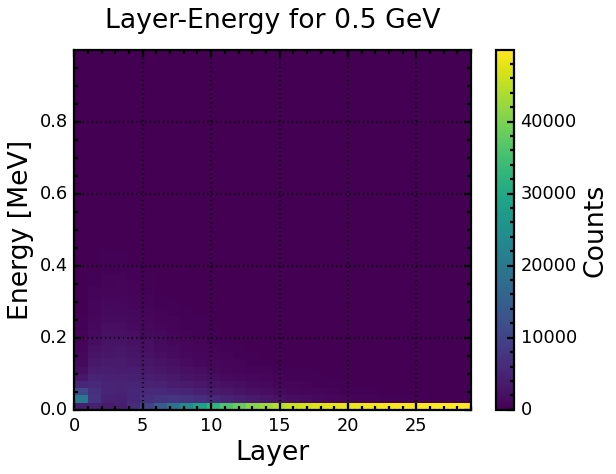

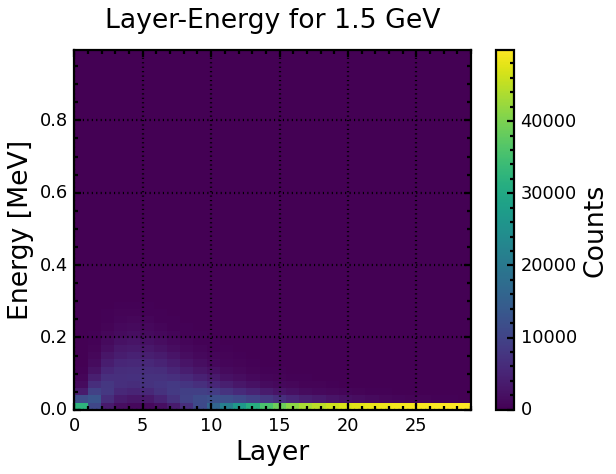

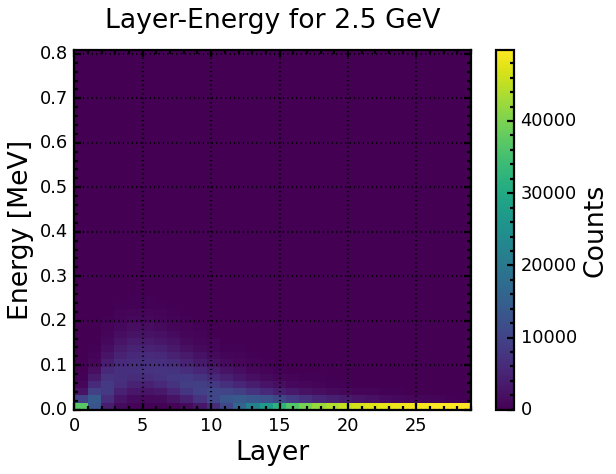

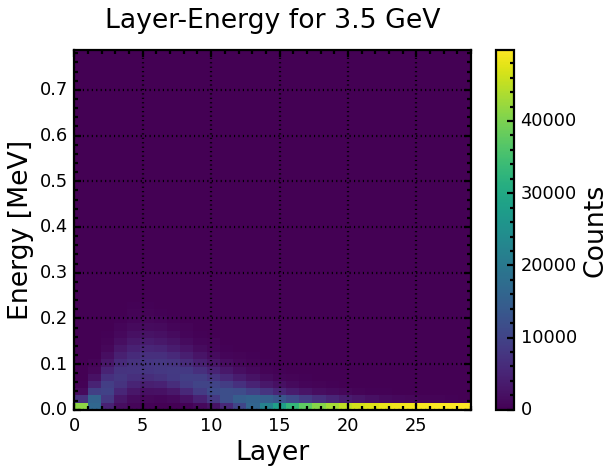

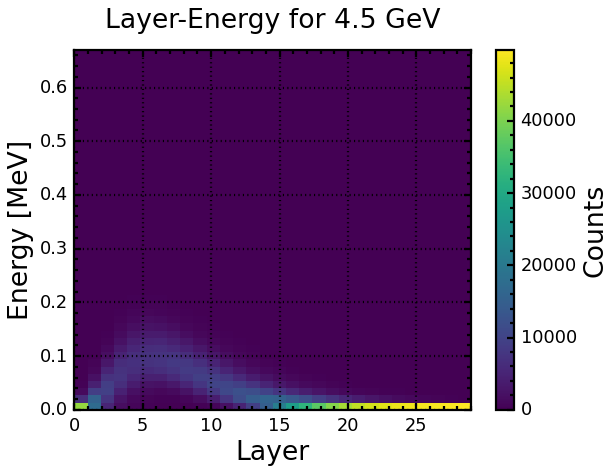

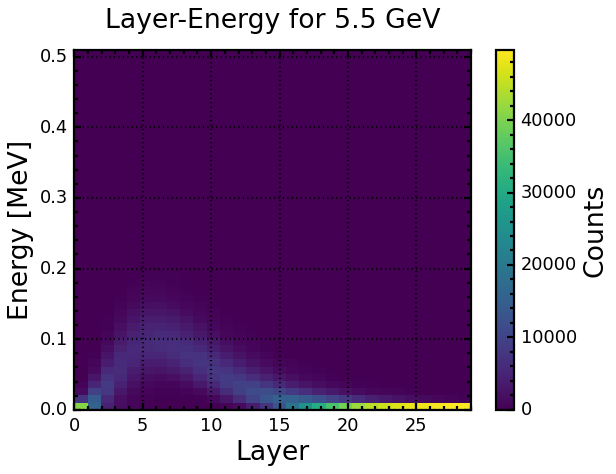

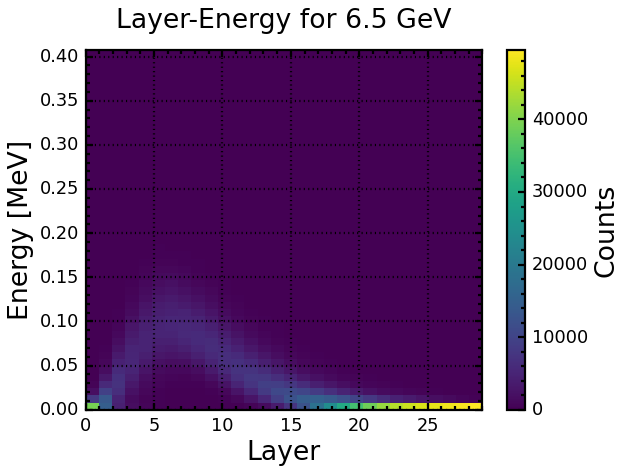

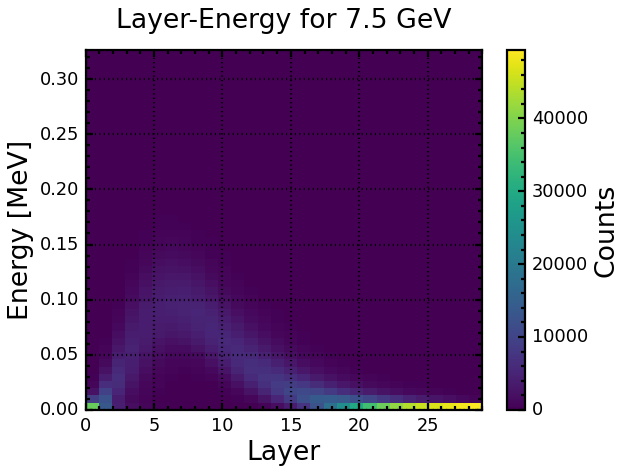

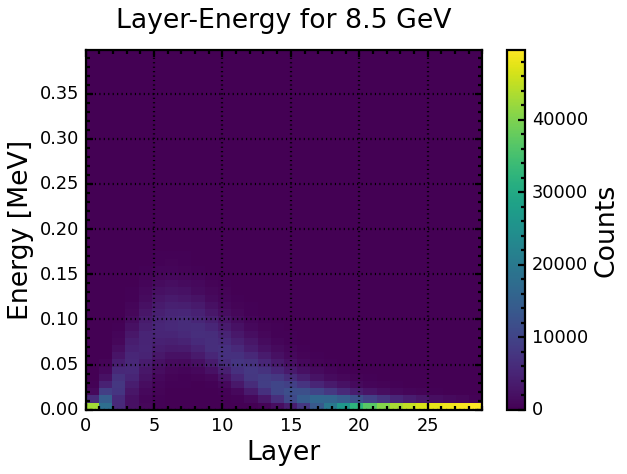

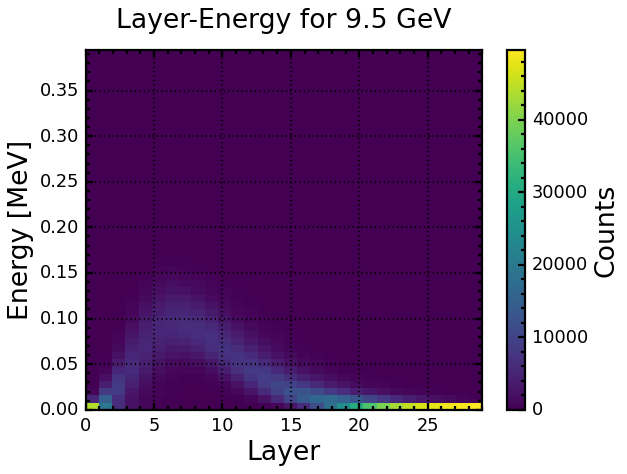

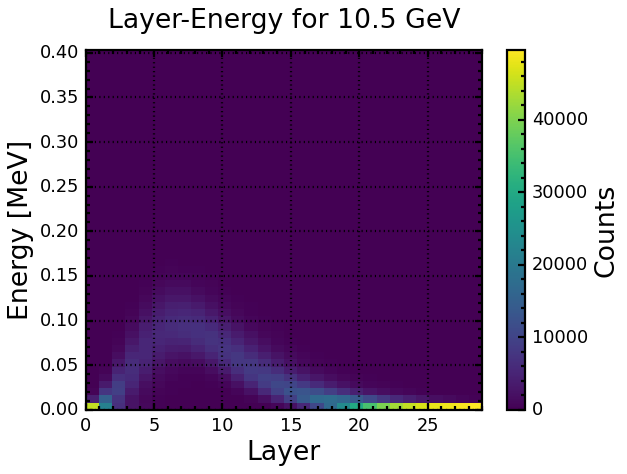

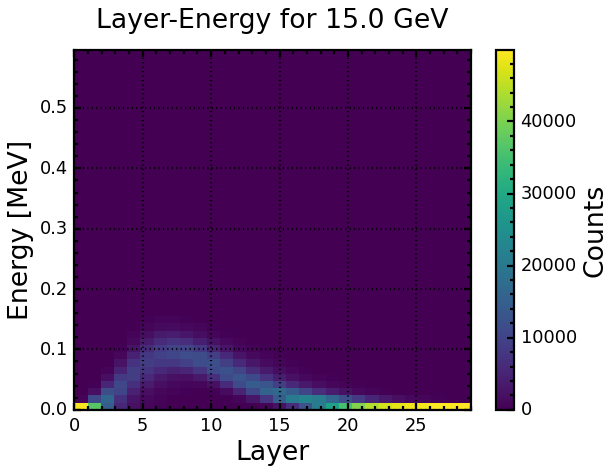

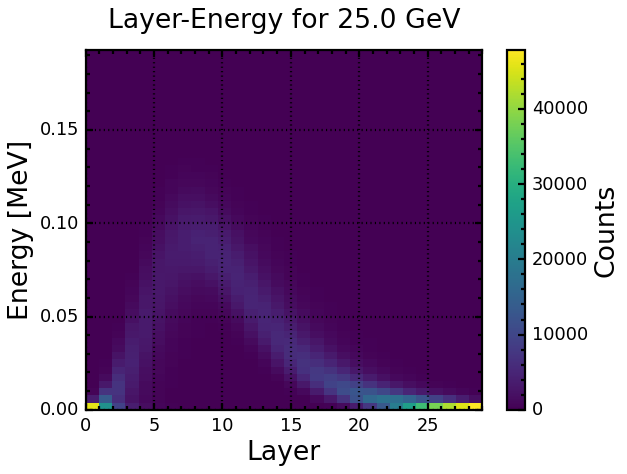

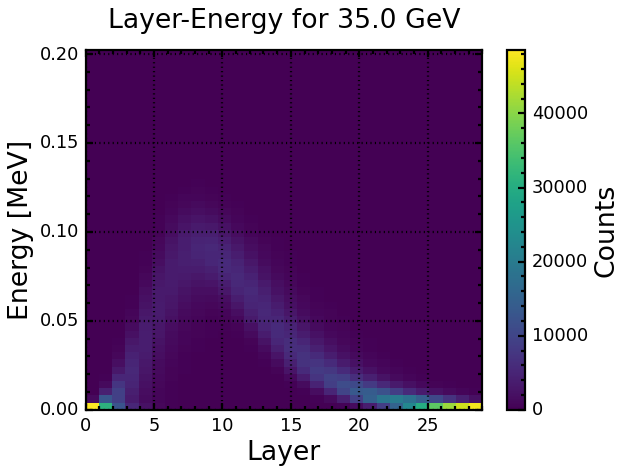

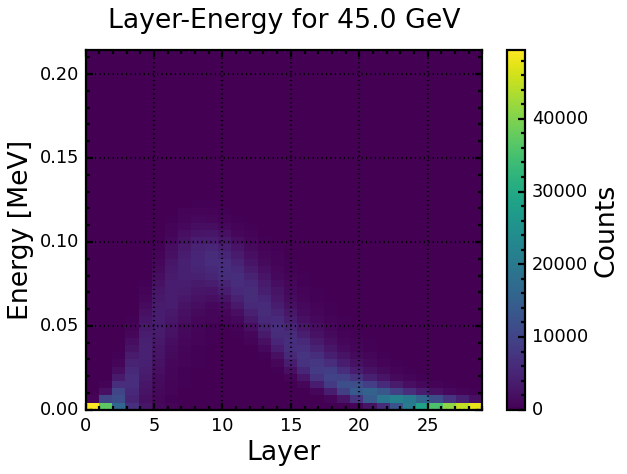

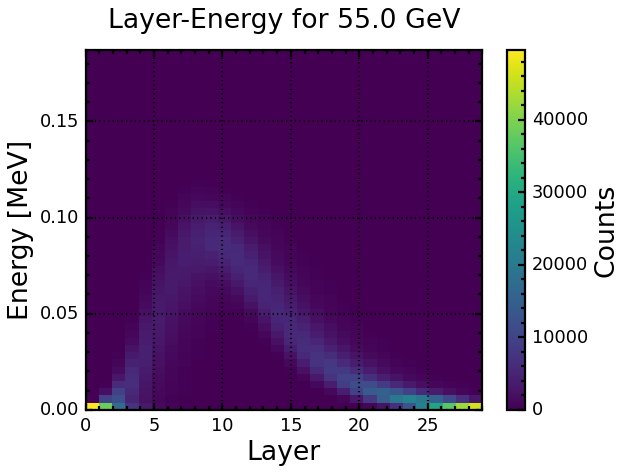

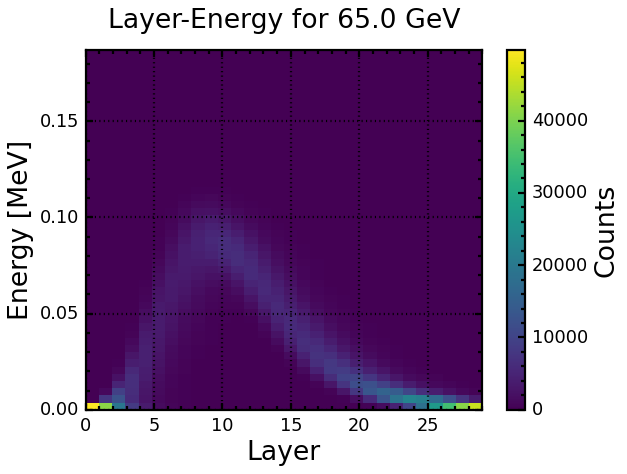

In [109]:
#2D hist Layer-Energy
for i_E, E_truth in enumerate(Energy_Train):
    mask = (E_truth_train == E_truth)
    E_layers = E_layers_train[mask]
    E_sum = np.sum(E_layers, axis=1) + 1e-6
    data = np.array(E_layers_train[mask]/E_sum[:, None])  # shape: (N, 30) 

    x = np.arange(data.shape[1])           # [0, 1, ..., 29]
    X = np.tile(x, data.shape[0])          # 展开 index
    Y = data.flatten()                     # 展开 values    

    plt.figure(figsize=(8,6))
    plt.hist2d(X, Y, bins=(30, 50), cmap='viridis')  # 30 bins for index, 50 for value
    plt.colorbar(label="Counts")    

    plt.xlabel("Layer")
    plt.ylabel("Energy [MeV]")
    plt.title(f"Layer-Energy for {E_truth} GeV")
    plt.show()


In [ ]:
#Graph start/end layer
start_layers = []
end_layers = []

for i_E, E_truth in enumerate(Energy_Train):
    mask = (E_truth_train == E_truth)
    data = np.array(N_layers_train[mask])  # shape: (n_samples, n_layers)
    
    starts = []
    ends = []
    for row in data:
        # 找到所有 >1 的层索引
        idx = np.where(row > 1)[0]
        if len(idx) > 0:
            starts.append(idx[0])   # 第一个
            ends.append(idx[-1])    # 最后一个
    
    # 记录该能量下的平均 start/end
    start_layers.append(np.mean(starts) if starts else np.nan)
    end_layers.append(np.mean(ends) if ends else np.nan)

# 转换为 array
start_layers = np.array(start_layers)
end_layers = np.array(end_layers)

# 画图
plt.figure(figsize=(8,6))
plt.plot(Energy_Train, start_layers, marker='o', label="Start Layer")
plt.plot(Energy_Train, end_layers, marker='s', label="End Layer")

plt.xlabel("Particle Energy")
plt.ylabel("Layer Index")
plt.title("Start/End Layer vs Particle Energy")
plt.legend(loc='upper left')
plt.show()



In [ ]:
#2D hist layer counts
n_layers = N_layers_train.shape[1]

plt.figure(figsize=(10,6))

for E_truth in Energy_Val:
    mask = (E_truth_validate == E_truth)
    data = np.array(N_layers_validate[mask])   # (n_events, n_layers)

    # 每层 hit 的事例数
    counts = np.sum(data > 1, axis=0)

    plt.plot(np.arange(n_layers), counts, marker='o', label=f"E={E_truth}GeV")

plt.xlabel("Layer")
plt.xlim(-5,55)
plt.ylabel("Events")
plt.title("Layer VS Events for Different Particle Energies")
plt.legend()
plt.show()



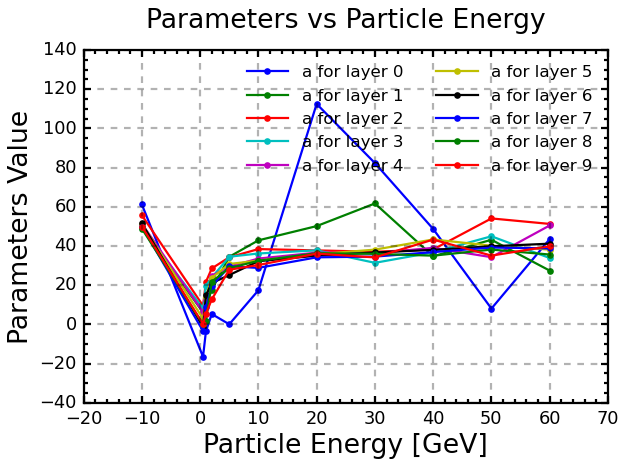

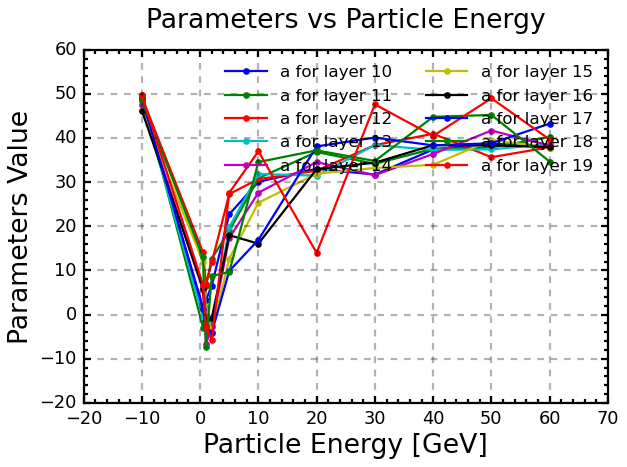

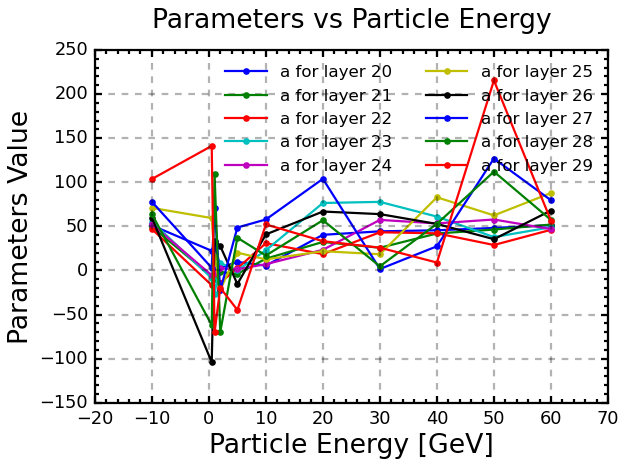

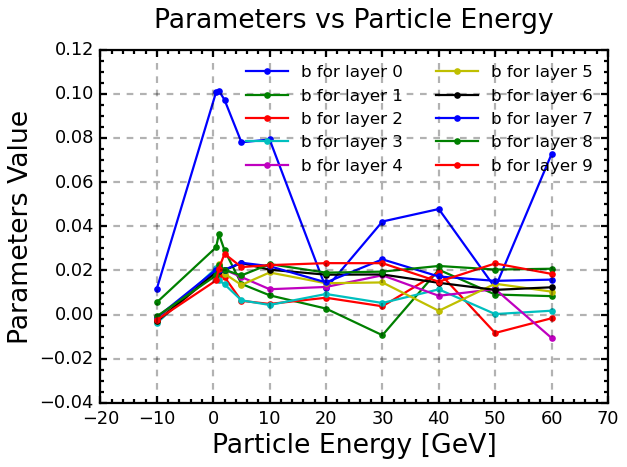

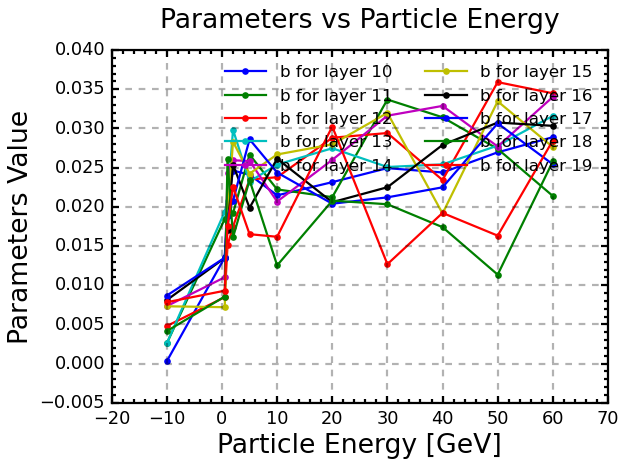

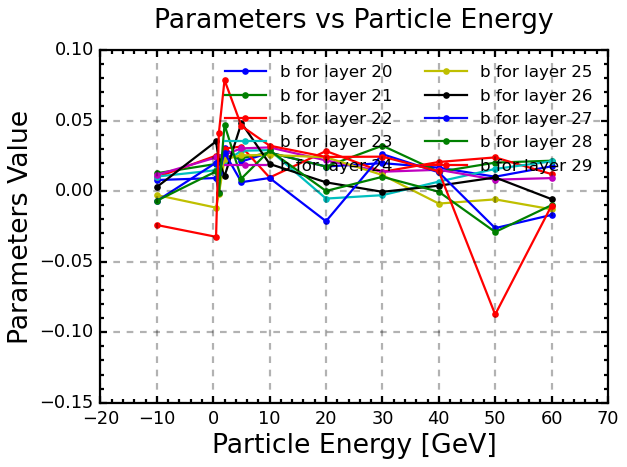

In [165]:
#normal method
Reco_hist = []
Reco_hist_cheat = []
coeffs_all = []
energies_all = []

import numpy as np

import numpy as np
def ConstructX(E_data, N_data):
    E_sum = np.sum(E_data, axis=1) + 1e-6  # shape: (Nsample,)
    N_sum = np.sum(N_data, axis=1) + 1e-6  # shape: (Nsample,)
    E_norm = E_data / E_sum[:, None]       # shape: (Nsample, Nlayer)
    N_norm = N_data / N_sum[:, None]       # shape: (Nsample, Nlayer)
    E_sum_col = E_sum[:, None]
    N_sum_col = N_sum[:, None]
    X = np.hstack([E_data, N_data])
    return X
def ConstructY(E_data, N_data,E_truth):
    E_sum = np.sum(E_data,axis=1)
    y = E_truth
    return y
def ConstructModel(E_data,N_data,E_truth):
    X = ConstructX(E_data, N_data)
    y = ConstructY(E_data, N_data, E_truth)
    coeffs, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)
    E_reco = X @ coeffs
    return coeffs
def ReconstructE(E_data,N_data,coeffs):
    E_sum = np.sum(E_data,axis=1)
    X = ConstructX(E_data, N_data)
    y = X @ coeffs
    return y
def ConstructHists(E_reco):
    Nbins = 50
    mean = np.mean(E_reco)
    rms = np.std(E_reco)
    mask = (E_reco >= mean - 5*rms) & (E_reco <= mean + 5*rms)
    filtered_data = E_reco[mask]
    counts, bin_edges = np.histogram(filtered_data, bins=Nbins)
    return counts, bin_edges

#Train
E_data,N_data,E_truth,E_Set=E_layers_validate,N_layers_validate,E_truth_validate,Energy_Val
coeffs=ConstructModel(E_data,N_data,E_truth)
coeffs_all.append(coeffs)
energies_all.append(-10)
for i_E, E_particle in enumerate(E_Set):
    mask = (E_truth == E_particle)
    E_reco = ReconstructE(E_data[mask], N_data[mask], coeffs)
    counts, bin_edges = ConstructHists(E_reco)
    Reco_hist.append({
        "E_truth": E_particle,
        "counts": counts,
        "bin_edges": bin_edges
    })

#cheat method
E_data,N_data,E_truth,E_Set=E_layers_validate,N_layers_validate,E_truth_validate,Energy_Val
for i_E, E_particle in enumerate(E_Set):
    mask = (E_truth == E_particle)
    coeffs = ConstructModel(E_data[mask], N_data[mask], E_truth[mask])
    coeffs_all.append(coeffs)
    energies_all.append(E_particle)
    E_reco_cheat = ReconstructE(E_data[mask], N_data[mask], coeffs)
    counts, bin_edges = ConstructHists(E_reco_cheat)
    if len(E_reco_cheat) == 0:
        continue  # 防止空集
    Reco_hist_cheat.append({
        "E_truth": E_particle,
        "counts": counts,
        "bin_edges": bin_edges
    })

coeffs_all = np.array(coeffs_all)  # shape: (n_energy, 60)


n_coeffs = coeffs_all.shape[1]  # 60
n_plots = 6
coeffs_per_plot = n_coeffs // n_plots  # 6

for i in range(n_plots):
    plt.figure(figsize=(8,6))
    start = i * coeffs_per_plot
    end = (start + coeffs_per_plot) if i < n_plots-1 else n_coeffs
    
    for j in range(start, end):
        if j < 30:
            label = f'a for layer {j}'
        else:
            label = f'b for layer {j-30}'
        plt.plot(energies_all, coeffs_all[:, j], marker='o', linestyle='-', label=label)
    
    plt.xlabel("Particle Energy [GeV]")
    plt.ylabel("Parameters Value")
    #plt.xscale("log")
    plt.title(f"Parameters vs Particle Energy")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(ncol=2, fontsize=15)
    plt.tight_layout()
    plt.show()



In [159]:
def fit_gamma(x, norm, k, mu, theta):
    return norm * gamma_dist.pdf(x, k, loc=mu, scale=theta)

def fit_log_normal(x, norm, sigma, loc, scale):
    """Log-normal distribution with location parameter."""
    return norm * log_normal_dist.pdf(x, s=sigma, loc=loc, scale=scale)

def fit_gaussian(x, norm, resolution, mean):
    return norm * gaussian_dist.pdf(x, loc=mean, scale=mean * resolution)

def fit_all(type,E_truth,counts,bin_edges):
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dx = bin_edges[1] - bin_edges[0]
    peak = bin_centers[np.argmax(counts)]
    mean = np.average(bin_centers, weights=counts)
    rms = np.sqrt(np.average((bin_centers - mean)**2, weights=counts))
    print(f"Mean: {mean}, Peak: {peak}, RMS: {rms}")
    plt.figure(figsize=fig_size)
    plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, label="Data", color='blue')

    #Gamma Fit
    #theta = abs(mean - peak)
    #k = rms / np.sqrt(theta)
    #mu = E_truth
    theta = max(rms, 1e-6)
    k = max((mean - bin_edges[0]) / theta, 1e-3)
    mu = max(bin_edges[0], mean - k*theta) # or try mean - k*theta
    norm = counts.sum() * dx
    params_gamma_initial = [norm, k, mu, theta]
    lower_bounds = [norm*0.01, k*0.1, mu*0.1-100, theta*0.1]
    upper_bounds = [norm*6, k*10, mu*1.5+10, theta*10]
    print(f"Initial Gamma Fit Parameters: {params_gamma_initial}")
    params_gamma, cov_gamma = curve_fit(fit_gamma, bin_centers, counts, p0=params_gamma_initial, bounds=(lower_bounds, upper_bounds))
    print(f"Gamma Fit Parameters: {params_gamma}")
    x_fit_gamma = np.linspace(bin_edges[0], bin_edges[-1], 100)
    y_fit_gamma = fit_gamma(x_fit_gamma, *params_gamma)
    #calculate peak and resolution
    k,mu,theta = params_gamma[1], params_gamma[2], params_gamma[3]
    peak_gamma = (k-1) * theta + mu
    J = np.array([0,theta, 1.0, (k - 1.0)])
    peak_gamma_error = np.sqrt(J @ cov_gamma @ J)
    #res
    res_gamma = np.sqrt(k) * theta / peak_gamma
    dr_dnorm = 0.0
    dr_dk = (0.5 / np.sqrt(k) * theta * peak_gamma - np.sqrt(k) * theta * (theta)) / (peak_gamma**2)
    dr_dmu = - np.sqrt(k) * theta / (peak_gamma**2)
    dr_dtheta = (np.sqrt(k) * peak_gamma - np.sqrt(k) * theta * (k - 1.0)) / (peak_gamma**2)
    J = np.array([dr_dnorm, dr_dk, dr_dmu, dr_dtheta])
    res_gamma_error = np.sqrt(J @ cov_gamma @ J)
    print(f"Gamma Fit Peak: {peak_gamma} ± {peak_gamma_error}, Resolution: {res_gamma} ± {res_gamma_error}")
    if type == "E":
        plt.title(f"Deposited Energy {E_truth} GeV")
        plt.xlabel("Deposited Energy [MeV]")
        plt.ylabel("Counts")
    elif type == "N":
        plt.title(f"Number of Hits {E_truth} GeV")
        plt.xlabel("Number of Hits")
        plt.ylabel("Counts")
    elif type == "E_reco":
        plt.title(f"Reconstructed Energy {E_truth} GeV")
        plt.xlabel("Reconstructed Energy [GeV]")
        plt.ylabel("Counts")
    else:
        print("Unknown type")
        return 0
    plt.plot(x_fit_gamma, y_fit_gamma, 'r-', label="Gamma Fit")
    #plt.xlim(peak_gamma - 4*peak_gamma*res_gamma, peak_gamma + 8*peak_gamma*res_gamma)
    #plt.yscale("log")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    return (peak_gamma, peak_gamma_error, res_gamma, res_gamma_error)


Mean: 0.4841529777367569, Peak: 0.4763222674926819, RMS: 0.08689807242693388
Initial Gamma Fit Parameters: [78.81170230775193, 4.535029275843392, 0.09006767526625231, 0.08689807242693388]
Gamma Fit Parameters: [7.81833432e+01 1.98364801e+01 1.14077810e-01 1.85840760e-02]
Gamma Fit Peak: 0.4641363870587104 ± 0.0016275335881709052, Resolution: 0.17833133480248725 ± 0.0028412897315020385


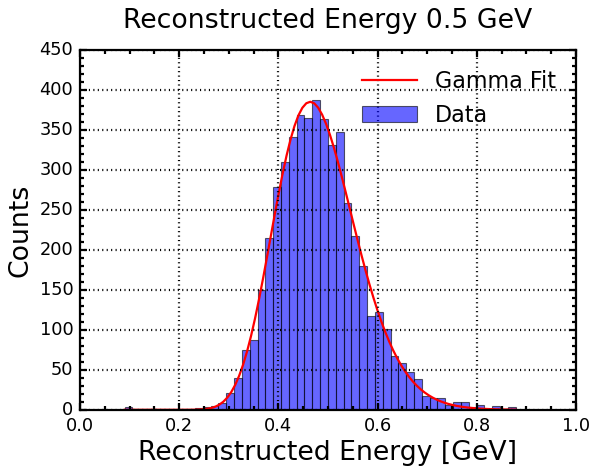

In [160]:
#This cell is left here for debug
i_E = 0  # Example index, change as needed
Hist = Reco_hist_cheat[i_E]
peak_gamma,peak_gamma_error,res_gamma,res_gamma_error = fit_all("E_reco",Hist["E_truth"],Hist["counts"],Hist["bin_edges"])





Mean: 0.49602829472404636, Peak: 0.4296748591357068, RMS: 0.13007245491448222
Initial Gamma Fit Parameters: [109.27772659476209, 3.6186064474481894, 0.02534727073508708, 0.13007245491448222]
Gamma Fit Parameters: [1.08768140e+02 1.01031874e+01 8.71203580e-02 4.05675593e-02]
Gamma Fit Peak: 0.45641445179204276 ± 0.0024467143877834846, Resolution: 0.28251967364454084 ± 0.005210408756644521


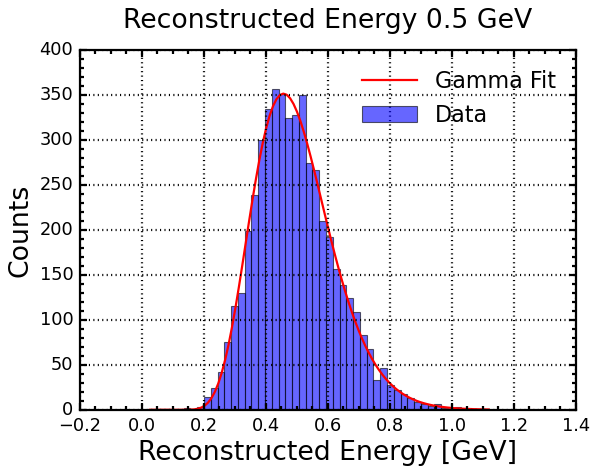

Mean: 0.9846675450588697, Peak: 0.9755287993516562, RMS: 0.1848473196567417
Initial Gamma Fit Parameters: [140.19476019767424, 3.007929383549359, 0.4286598607930153, 0.1848473196567417]
Gamma Fit Parameters: [1.40306148e+02 1.83622985e+01 1.89558982e-01 4.33357377e-02]
Gamma Fit Peak: 0.9419669951643225 ± 0.00312367524796607, Resolution: 0.19713967169806038 ± 0.0027491616810713555


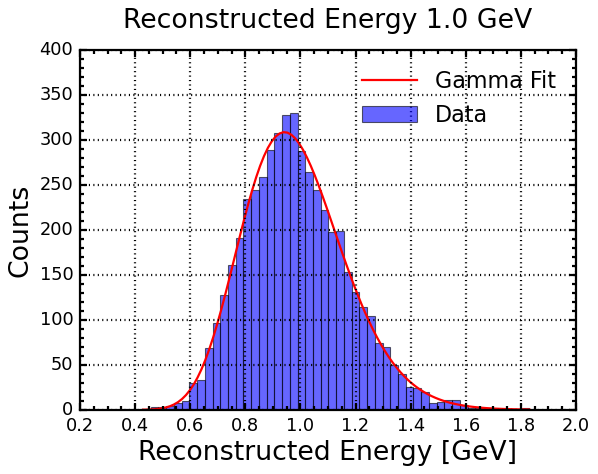

Mean: 1.9778834951181115, Peak: 1.9772575019844827, RMS: 0.26176163777617584
Initial Gamma Fit Parameters: [211.48416676636805, 3.3148901582656314, 1.1101724182423731, 0.26176163777617584]
Gamma Fit Parameters: [2.11218958e+02 3.31489016e+01 4.74126745e-01 4.54529618e-02]
Gamma Fit Peak: 1.9353895413487614 ± 0.00540796496946752, Resolution: 0.13521608878486474 ± 0.0020749580725523565


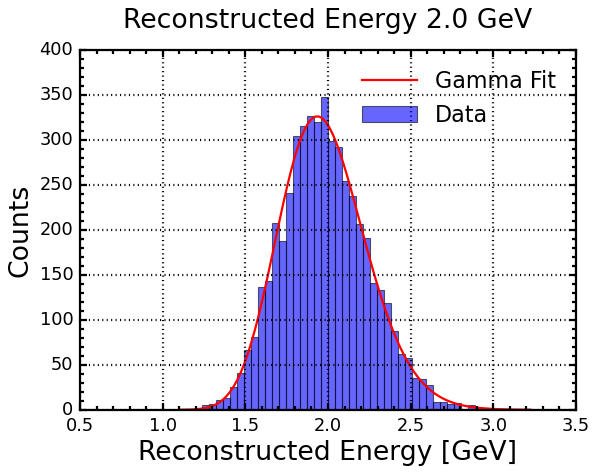

Mean: 5.007520851817306, Peak: 5.00364309947828, RMS: 0.41793171664299206
Initial Gamma Fit Parameters: [349.69772180450656, 3.441261067829698, 3.5693087063225444, 0.41793171664299206]
Gamma Fit Parameters: [3.53049917e+02 3.44126107e+01 2.47994781e+00 7.38755595e-02]
Gamma Fit Peak: 4.948323120128061 ± 0.007527224033299514, Resolution: 0.08757931480247629 ± 0.0010975408764373018


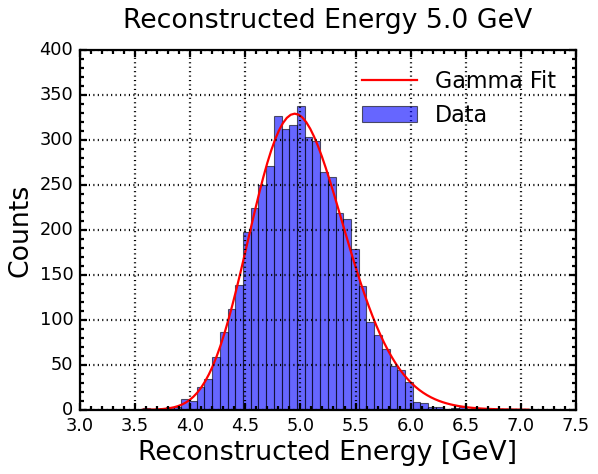

Mean: 10.06513058892034, Peak: 10.01798839279919, RMS: 0.5959236839142881
Initial Gamma Fit Parameters: [486.81779564907583, 4.57392712101811, 7.339419089007754, 0.5959236839142881]
Gamma Fit Parameters: [4.84910141e+02 4.57392712e+01 6.11016087e+00 8.72147320e-02]
Gamma Fit Peak: 10.012084416770419 ± 0.013703844406891262, Resolution: 0.058912841231294574 ± 0.0009517539489760221


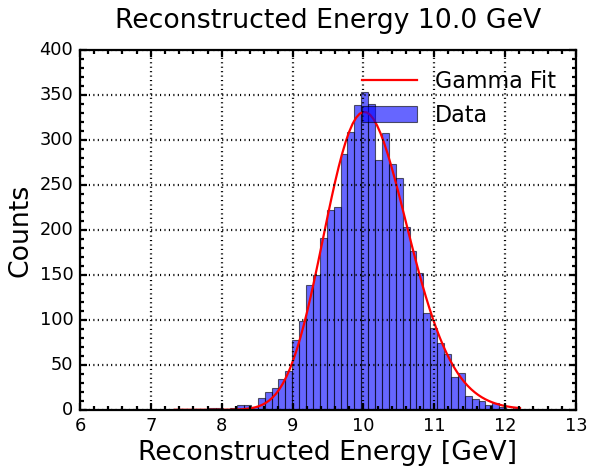

Mean: 20.11897465541982, Peak: 20.18169357196745, RMS: 0.8382385983418051
Initial Gamma Fit Parameters: [703.8962052749829, 3.5389185294287606, 17.152516547665613, 0.8382385983418051]
Gamma Fit Parameters: [7.04092146e+02 3.53891853e+01 1.51622331e+01 1.41371002e-01]
Gamma Fit Peak: 20.02386669742165 ± 0.020438170748645304, Resolution: 0.04199984363591638 ± 0.0007193254066956482


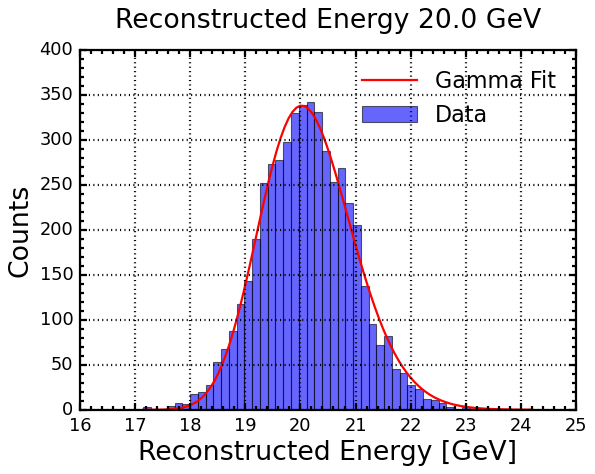

Mean: 30.11772513893122, Peak: 30.11574936764066, RMS: 1.0412893572155233
Initial Gamma Fit Parameters: [930.4770382039907, 5.278250110330467, 24.621539474322443, 1.0412893572155233]
Gamma Fit Parameters: [9.29919430e+02 5.27825011e+01 2.26358889e+01 1.43061631e-01]
Gamma Fit Peak: 30.04397796287397 ± 0.025504562906678123, Resolution: 0.034594791751395966 ± 0.000578790307677554


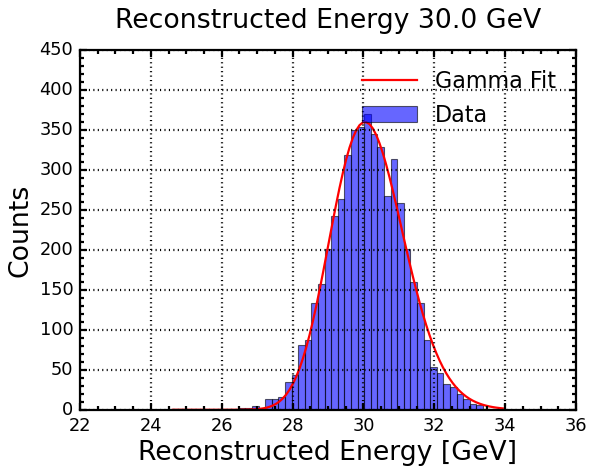

Mean: 40.04430135009555, Peak: 40.13012548530986, RMS: 1.1818569447522969
Initial Gamma Fit Parameters: [1068.6255725980266, 4.182190041967489, 35.101551004722374, 1.1818569447522969]
Gamma Fit Parameters: [1.06916005e+03 4.18219004e+01 3.24504637e+01 1.83410385e-01]
Gamma Fit Peak: 39.9376241706633 ± 0.025606205926928437, Resolution: 0.02969911979676043 ± 0.0004434377649887253


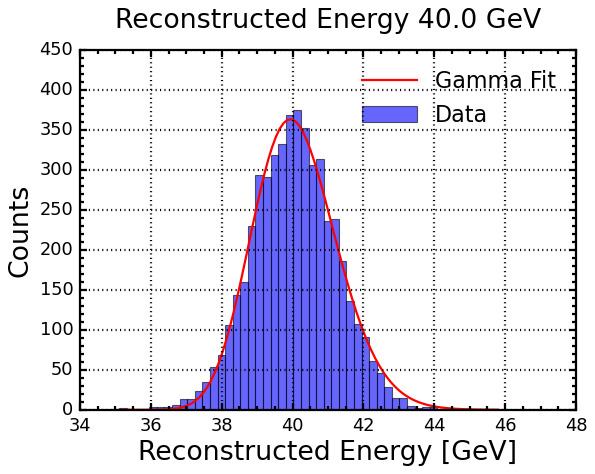

Mean: 49.953413537942076, Peak: 50.11002120245152, RMS: 1.3158009402924806
Initial Gamma Fit Parameters: [989.5387339313831, 4.018042486948946, 44.666469455479515, 1.3158009402924806]
Gamma Fit Parameters: [9.85535136e+02 4.01804249e+01 4.17352479e+01 2.06973296e-01]
Gamma Fit Peak: 49.84454954063995 ± 0.04048478421424599, Resolution: 0.02632109201851923 ± 0.0005630659959498282


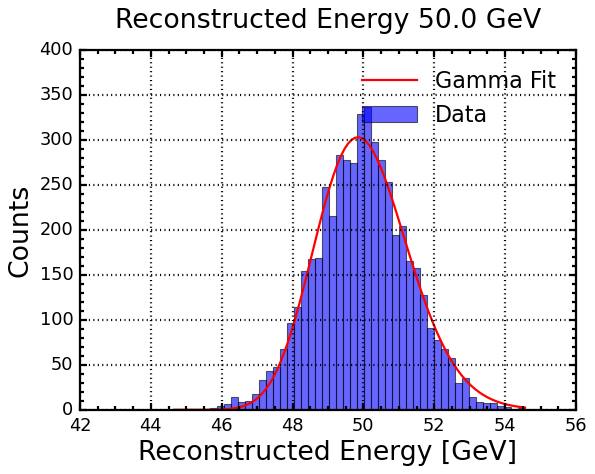

Mean: 59.787002573435, Peak: 59.66704980091573, RMS: 1.4561564031766843
Initial Gamma Fit Parameters: [1241.8000868081429, 4.263571048028054, 53.57857629145022, 1.4561564031766843]
Gamma Fit Parameters: [1.23607810e+03 4.26357105e+01 5.04556689e+01 2.21445094e-01]
Gamma Fit Peak: 59.675692767044 ± 0.03331037011839364, Resolution: 0.024230107788539092 ± 0.00038470191625347347


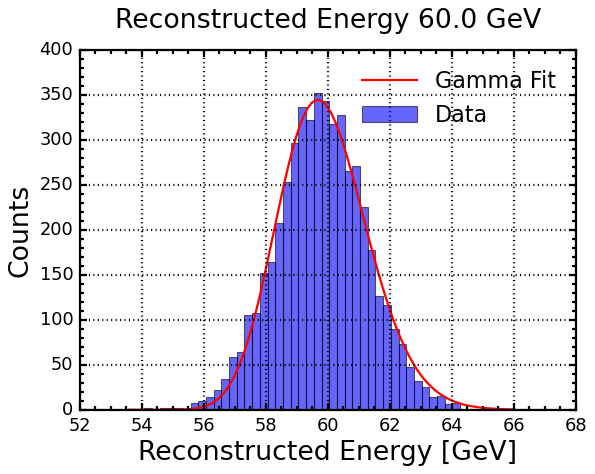

In [162]:
#Fit RecoE and Save as CSV
#Gauss and LogNormal were not fitted but saved as 0 to keep format
results = []
for i_E in range(len(Energy_Val)):
    peak_gauss, peak_gauss_error, res_gauss, res_gauss_error = 0, 0, 0, 0
    peak_log_normal, peak_log_normal_error, res_log_normal, res_log_normal_error = 0, 0, 0, 0
    Hist = Reco_hist[i_E]
    peak_gamma, peak_gamma_error, res_gamma, res_gamma_error = fit_all("E_reco",Hist["E_truth"],Hist["counts"],Hist["bin_edges"])
    results.append({
        "ParticleEnergy": Energy_Val[i_E],
        "Peak_Gauss": peak_gauss,
        "Peak_Gauss_Error": peak_gauss_error,
        "Res_Gauss": res_gauss,
        "Res_Gauss_Error": res_gauss_error,
        "Peak_Gamma": peak_gamma,
        "Peak_Gamma_Error": peak_gamma_error,
        "Res_Gamma": res_gamma,
        "Res_Gamma_Error": res_gamma_error,
        "Peak_LogNormal": peak_log_normal,
        "Peak_LogNormal_Error": peak_log_normal_error,
        "Res_LogNormal": res_log_normal,
        "Res_LogNormal_Error": res_log_normal_error
    })
df = pd.DataFrame(results)
outputfile_name = os.path.join(DataPath_Validate, "RecoE_LW_Fit.csv")
df.to_csv(outputfile_name, index=False)

